DIVA

In [2]:
%matplotlib inline
import os
import itertools
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import pearsonr, shapiro, anderson
from scipy.spatial import ConvexHull
import matplotlib.ticker as ticker
from exploration.data.data import load_sim_h5
from results_utils import *
from exploration.algorithm.utils.logging import read_config_log

colors_ = ['firebrick', 'darkgreen', 'navy',  'deepskyblue', 'm','goldenrod', 'black', 'grey']

def create_dict(groups_k):
    return {k[0] + '_' + k[1]: [] for k in groups_k}

def incremental_mean(arr_):
    n_samples = len(arr_)
    sum_ = 0
    out = []
    for i in range(n_samples):
        sum_ += arr_[i]
        out += [sum_/(i + 1.)]
    out = np.array(out).flatten()
    return out

def moving_av(arr_, win_sz):
    n_samples = len(arr_)
    sum_ = 0
    out = []
    for i in range(win_sz):
        sum_ += arr_[i]
        out += [sum_/(i + 1.)]
    for i in range(win_sz,n_samples):
        sum_ = sum_ + arr_[i] - arr_[i-win_sz]
        out += [sum_/win_sz]
    out = np.array(out).flatten()
    return out

def std_markers(ax,y,m,sz,color='b'):
    plt.sca(ax)
    for i,(y_,ms_) in enumerate(zip(y,sz)):
        plt.plot(i, y_, marker = m, ms = ms_, color = color)
        
def get_stat_test(dict_):
    thresh = []
    values  = []
    for key in dict_.keys():
        if 'autonomous' in key:
            continue
        values += [dict_[key]]
        key = key.split('&')
        key[0] = key[0].replace('_','.')
        thresh += [float(key[0])]

    return pearsonr(thresh, values)

In [3]:
n_samples = 102000
# Group by:
type_ops = ['proprio']
mode_ops = ['autonomous_1','autonomous_2','autonomous_3']

groups_k = list(itertools.product(type_ops, mode_ops)) #+ [['proprio','autonomous']]


#container for error
means_e = create_dict(groups_k)
means_av_e = create_dict(groups_k)

#container for social error
means_s = create_dict(groups_k)
means_av_s = create_dict(groups_k)
means_std_s = create_dict(groups_k)

#container for whole evaluation error 
means_w = create_dict(groups_k)
means_av_w = create_dict(groups_k)
means_std_w = create_dict(groups_k)

#container for convex hulls
ch_ = create_dict(groups_k)
ch_av = create_dict(groups_k)
ch_std = create_dict(groups_k)

#container for interactions social eval
means_inter_s = create_dict(groups_k)
means_inter_av_s = create_dict(groups_k)
stds_inter_av_s = create_dict(groups_k)

#container for interactions whole eval
means_inter_w = create_dict(groups_k)
means_inter_av_w = create_dict(groups_k)
stds_inter_av_w = create_dict(groups_k)

#container for acomulated collisions
coll_e = create_dict(groups_k)
coll_av_e = create_dict(groups_k)

#container for collisions in social evaluation (not used)
coll_s = create_dict(groups_k)
coll_av_s = create_dict(groups_k)
coll_std_s = create_dict(groups_k)

#container for collisions in whole evaluation (not used)
coll_w = create_dict(groups_k)
coll_av_w = create_dict(groups_k)
coll_std_w = create_dict(groups_k)

#container for interactions data 
inter = create_dict(groups_k)
inter_av = create_dict(groups_k)
inter_std = create_dict(groups_k)

inter_evo = create_dict(groups_k)
inter_evo_av = create_dict(groups_k)

#container for errors
error_ev = create_dict(groups_k)
error_ev_av = create_dict(groups_k)

#container for standar deviations
std_ev = create_dict(groups_k)

#container for competence during exploration
comp_w = create_dict(groups_k)
comp_av_w = create_dict(groups_k)

# Constraint violations during evaluation
cons_ev_whole = create_dict(groups_k)
cons_ev_whole_av = create_dict(groups_k)
std_cons_ev_whole = create_dict(groups_k)

In [4]:
directories = [
                'diva_results/diva_experiment_thesis_chap_5/', 
                'diva_IEEE_SI/experiment_IEEE_SI_slopes_cmf_323/',
                'diva_results/diva_experiment_thesis_chap_5_all_dell/'
#                 'diva_results/diva_experiment_thesis_chap_6_social_all/',
#                 'diva_results/diva_experiment_thesis_chap_6_social_all_no_slope/'
#                 'diva_IEEE_SI/experiment_IEEE_SI_slopes_cmf_223/'
                ]

for directory in directories:
    data_files = os.listdir(directory)

    for data_file in (d_f for d_f in data_files if 'sim_data.h5' in d_f):
        data_file = directory + data_file
        conf_file = data_file.replace('sim_data.h5', 'conf.txt')
#         try:

        conf = read_config_log(conf_file)
    
        if conf['type'] == 'social' or conf['mode'] == 'social':
            continue
    
        if 'IEEE_SI' in directory :
            conf_tmp = conf['mode']
#             conf['mode'] = conf['type'] 
            conf['mode'] = conf_tmp + '_2'
            
        elif 'dell' in directory :
            conf['mode'] = conf['mode']+'_3'
        else:
            conf['mode'] = conf['mode']+'_1'
#         if conf['slope'] != '0.96}':
#             continue
#         print conf['slope']
        
        whole_data, foo = load_sim_h5(data_file)
        interaction_data = whole_data.social.data.as_matrix(columns=None)
        interactions = np.zeros((interaction_data.shape[0],))
        interactions[~np.isnan(interaction_data[:, 0])] = 1

        try:
            social_data, foo = load_sim_h5(data_file.replace('sim_data.h5', 'sensor_eva_valset.h5'))
        except:
            social_data, foo = load_sim_h5(data_file.replace('sim_data.h5', '_German_Vowels_sensor_eva_valset.h5'))

        
        s_error_ = np.linalg.norm(social_data.sensor_goal.data.as_matrix() -
                                  social_data.sensor.data.as_matrix(), axis=1)

        s_con_v = social_data.somato.data.as_matrix()

        w_error_ = np.linalg.norm(whole_data.sensor_goal.data.as_matrix() -
                                  whole_data.sensor.data.as_matrix(), axis=1)

        w_con_v = whole_data.cons.data.as_matrix()

        w_comp_w = whole_data.competence.data.as_matrix()

        eva_errors = []
        
        try: 
            with open(data_file.replace('sim_data.h5', 'eval_error.txt'), 'r') as f:
                for line in f:
                    line.replace('\n','')
                    line.replace('\r', '')
                    eva_errors_str = line.split(': ')
                    eva_errors += [float(eva_errors_str[1])]
        except:
            with open(data_file.replace('sim_data.h5', '_German_Vowels_eval_error.txt'), 'r') as f:
                for line in f:
                    line.replace('\n','')
                    line.replace('\r', '')
                    eva_errors_str = line.split(': ')
                    eva_errors += [float(eva_errors_str[1])]
#         eva_cons_whole = []
#         with open(data_file.replace('sim_data.h5', 'eval_error.txt'), 'r') as f:
#             for line in f:
#                 line.replace('\n', '')
#                 line.replace('\r', '')
#                 eva_cons_str = line.split(': ')
#                 #In the newes version the ratio is returned already divided by the len of the eval dataset
#                 eva_cons_whole += [float(eva_cons_str[1])]

        key = conf['type'] + '_' + conf['mode']
#         if 'slope' in directory:
#             key =  key + '_slope'


        means_s[key] += [np.mean(s_error_)]
        means_w[key] += [np.mean(w_error_)]

        coll_s[key] += [s_con_v[:n_samples]]
        coll_w[key] += [w_con_v[:n_samples]]

        inter[key] += [interactions[:n_samples]]

        error_ev[key] += [eva_errors]
#         cons_ev_whole[key] += [eva_cons_whole]

        comp_w[key] += [w_error_[:n_samples]]

legend = []
max_std = 0
max_std_cons_whole = 0

for i, k in enumerate(groups_k):
    group = k[0] + '_' + k[1]

    means_av_s[group] = np.mean(np.array(means_s[group]))
    means_av_w[group] = np.mean(np.array(means_w[group]))

    coll_av_s[group] = np.mean(np.array(coll_s[group]), axis=0)
    coll_av_w[group] = np.mean(np.array(coll_w[group]), axis=0)

    inter_av[group] = np.mean(np.array(inter[group]), axis=0)

    comp_av_w[group] = np.mean(np.array(comp_w[group]), axis=0)

    error_ev_av[group]= np.mean(np.array(error_ev[group]),axis=0)
    std_ev[group] = np.std(np.array(error_ev[group]),axis=0)
    max_std = max(max_std,max(std_ev[group].flatten()))
    
#     cons_ev_whole_av[group]= np.mean(np.array(cons_ev_whole[group]),axis=0)
#     std_cons_ev_whole[group] = np.std(np.array(cons_ev_whole[group]),axis=0)
#     max_std_cons_whole = max(max_std_cons_whole,max(std_cons_ev_whole[group].flatten()))
    
print(max_std)
# print(max_std_cons_whole)

0.35809434910339477


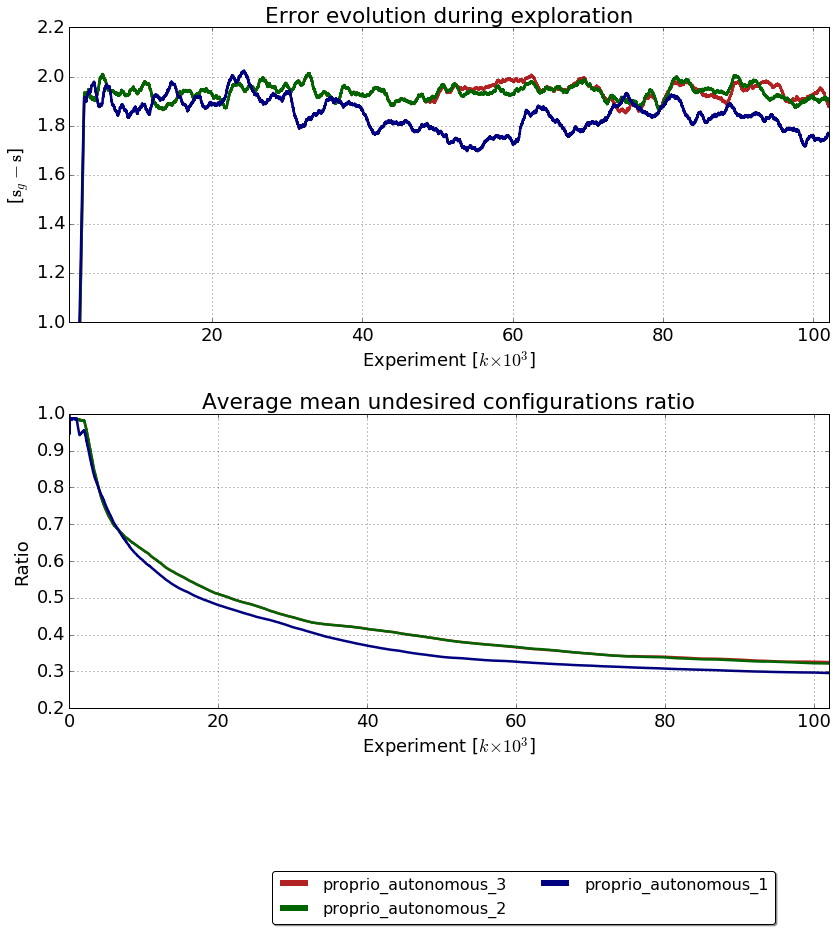

In [5]:
matplotlib.rcParams['figure.figsize'] = (12.0, 11)
matplotlib.rcParams.update({'font.size': 18})
matplotlib.rcParams.update({'lines.linewidth': 2.5})
win_sz=1000

x = np.linspace(0, len(moving_av(comp_av_w[comp_av_w.keys()[0]],win_sz)), \
                len(moving_av(comp_av_w[comp_av_w.keys()[0]],win_sz)))
scale_x = 1e3
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_x))

fig1, ax1 = plt.subplots(2,1)
plt.sca(ax1[0])
ax1[0].set_title('Error evolution during exploration')

for key, color in zip(error_ev_av.keys(), colors_):
    data_plt = moving_av(comp_av_w[key],win_sz)
    ax1[0].plot(data_plt, linestyle='-', marker='', color=color)
ax1[0].set_xlabel('Experiment [$k$' + r'$\times$' + '$10^3$]')
ax1[0].set_ylabel(r'[$\mathbf{s}_g-\mathbf{s}$]')
ax1[0].set_xlim([1000,n_samples])
ax1[0].set_ylim([1.,2.2])
ax1[0].xaxis.set_major_formatter(ticks_x)

plt.sca(ax1[1])
ax1[1].set_title('Average mean undesired configurations ratio')
for key, color in zip(error_ev_av.keys(), colors_):
    data_plt = incremental_mean(coll_av_w[key])
    ax1[1].plot(data_plt, linestyle='-', marker='',color=color)
ax1[1].set_xlabel('Experiment [$k$' + r'$\times$' + '$10^3$]')
ax1[1].set_ylabel('Ratio')
ax1[1].set_xlim([0,n_samples])
# ax1[1].set_ylim([0.25,1])
ax1[1].xaxis.set_major_formatter(ticks_x)

lds_ = []
for key, color in zip(error_ev_av.keys(), colors_):
#     key = key.replace('_autonomous',' ')
#     key = key.replace('simple','Simple group')
#     key = key.replace('proprio','Somesthetic group')
#     key = key.replace('_pain','(No pain during initialization)')
    lds_ += [key]

lgd = plt.legend(lds_,\
            ncol=2,loc='lower right',fontsize=16, bbox_to_anchor=(0.94, -.76),
          fancybox=True, shadow=True)

for legobj in lgd.legendHandles:
    legobj.set_linewidth(6.0)
for ax in ax1:
    ax.grid(True)
plt.tight_layout()


In [26]:
# fig1.savefig('/home/yumilceh/Dropbox/Aplicaciones/ShareLaTeX/PhD_Thesis/chapters/chapter5/images/vt_results_evo.eps',
#              format='eps', dpi=1000,bbox_extra_artists=(lgd,), bbox_inches='tight')

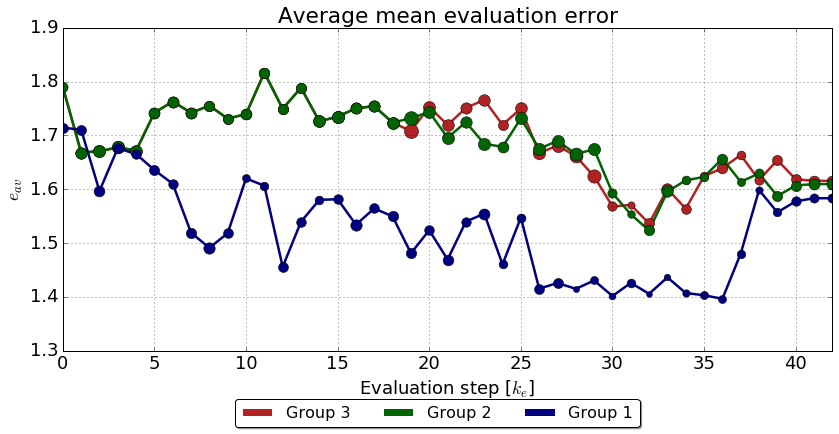

In [20]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.)
matplotlib.rcParams.update({'font.size': 18})
matplotlib.rcParams.update({'lines.linewidth': 2.5})


fig3, ax3 = plt.subplots(1,1)
plt.sca(ax3)
ax3.set_title('Average mean evaluation error')
for key, color in zip(error_ev_av.keys(), colors_):
    data_plt = error_ev_av[key]
    ax3.plot(data_plt, linestyle='-', marker='', color=color)
for key, color in zip(error_ev_av.keys(), colors_):
    data_plt = error_ev_av[key]
    ms = [(x/max_std)*13 + 1 for x in std_ev[key]]
    std_markers(ax3,error_ev_av[key],'o',ms,color=color)
plt.xlabel('$k_{eval}$')
plt.ylabel('$e_{av}$')
# ax3[0].set_ylim([1.3,1.8])
ax3.set_xlim([0,42])

plt.xlabel('Evaluation step [$k_e$]')
# plt.ylabel(r'Ratio')
# # ax3[1].set_xlim([0,len(data_plt)-1])
# # ax3[0,0].set_ylim([0.07,0.15]) 

lds_ = []
for key, color in zip(cons_ev_whole_av.keys(), colors_):
    key = key.replace('proprio_autonomous_','Group ')
    lds_ += [key]

lgd = plt.legend(lds_,\
            ncol=3,loc='lower right',fontsize=16, bbox_to_anchor=(0.76, -.26),
          fancybox=True, shadow=True)

for legobj in lgd.legendHandles:
    legobj.set_linewidth(7.0)
    ax3.grid(True)
plt.tight_layout()


In [ ]:
#Analisis of interactions with the instructor


In [22]:
for key, color in zip(cons_ev_whole_av.keys(), colors_):
    print key
    

proprio_social
simple_social_slope
simple_social
proprio_social_slope


In [5]:
for key in cons_ev_whole.keys():
    print key
    print cons_ev_whole[key]
    
# for key, color in zip(error_ev_av.keys(), colors_):
#     data_plt = incremental_mean(coll_av_w[key])
#     ax1[2].plot(data_plt, linestyle='-', marker='',color=color)

proprio_social
[[0.761609907121, 0.767801857585, 0.767801857585, 0.767801857585, 0.764705882353, 0.761609907121, 0.823529411765, 0.74613003096, 0.749226006192, 0.767801857585, 0.696594427245, 0.743034055728, 0.752321981424, 0.795665634675, 0.804953560372, 0.798761609907, 0.736842105263, 0.8173374613, 0.811145510836, 0.814241486068, 0.823529411765, 0.767801857585, 0.798761609907, 0.8173374613, 0.777089783282, 0.74613003096, 0.832817337461, 0.783281733746, 0.823529411765, 0.767801857585, 0.783281733746, 0.801857585139, 0.792569659443, 0.780185758514, 0.795665634675, 0.786377708978, 0.777089783282, 0.777089783282, 0.808049535604, 0.780185758514, 0.755417956656, 0.767801857585, 0.767801857585], [0.934984520124, 0.941176470588, 0.965944272446, 0.94427244582, 0.94427244582, 0.94427244582, 0.94427244582, 0.950464396285, 0.953560371517, 0.953560371517, 0.953560371517, 0.953560371517, 0.953560371517, 0.947368421053, 0.953560371517, 0.953560371517, 0.956656346749, 0.981424148607, 0.953560371517,

In [8]:
for key in comp_av_w.keys():
    print key
    print np.mean(comp_av_w[key])

simple_autonomous
2.045012800461771
proprio_autonomous
1.8159147142195047
simple_autonomous_pain
2.090849369122228
proprio_autonomous_pain
1.8548052035863858


In [24]:
for key in error_ev_av.keys():
    print key
    print incremental_mean(coll_av_w[key])[-1]
    

simple_autonomous
0.9175594059403869
proprio_autonomous
0.29600165016504904
simple_autonomous_pain
0.9107805280525902
proprio_autonomous_pain
0.3057475247524909


In [6]:
#container for convex hulls
ch_ = create_dict(groups_k)
ch_av = create_dict(groups_k)
ch_std = create_dict(groups_k)

#container for unarticulated productions
means_unart_s = create_dict(groups_k)
means_unart_av_s = create_dict(groups_k)
stds_unar_s = create_dict(groups_k)

#container for coarticulated productions
means_coart_s = create_dict(groups_k)
means_coart_av_s = create_dict(groups_k)
stds_coar_s = create_dict(groups_k)

for directory in ['diva_experiment_thesis_chap_5/', 'diva_experiment_thesis_chap_5_non_painful/']:
    
    data_files = os.listdir(directory)
    for data_file in (d_f for d_f in data_files if 'sim_data.h5' in d_f):
        data_file = directory + data_file
        conf_file = data_file.replace('sim_data.h5', 'conf.txt')
        conf = read_config_log(conf_file)
        key = conf['type'] + '_' + conf['mode']
        if 'pain' in directory:
            key =  key + '_pain'
        
        data,foo = load_sim_h5(data_file)
        sensor_data = data.sensor.data.as_matrix(columns=None)

        ch_[key] += [ConvexHull(sensor_data[:,[0,1,3,4]],qhull_options='Q12').volume]
        means_unart_s[key] += [float(np.where(np.logical_xor(sensor_data[:,2]>0.1, sensor_data[:,5]>0.1))[0].shape[0])/float(n_exp)]
        means_coart_s[key] += [float(np.where(np.logical_and(sensor_data[:,2]>0.1, sensor_data[:,5]>0.1))[0].shape[0])/float(n_exp)]


In [7]:
legend = []
max_std = 0
for i, group in enumerate(groups_k):
    legend += [group]
    group = group[0] + '_' + group[1]

    ch_av[group] = np.mean(np.array(ch_[group]))
    ch_std[group] = np.std(np.array(ch_[group]))
    
    means_unart_av_s[group] = np.mean(np.array(means_unart_s[group]))
    stds_unar_s[group] = np.std(np.array(means_unart_s[group]))

    means_coart_av_s[group] = np.mean(np.array(means_coart_s[group]))
    stds_coar_s[group] = np.std(np.array(means_coart_s[group]))

lds_ = []
for key in error_ev_av.keys():
    key = key.replace('_autonomous',' ')
    key = key.replace('simple','Simple')
    key = key.replace('proprio','Somesthetic')
    key = key.replace('_pain','(No pain during initialization)')
    lds_ += [key]
print(lds_)

['Simple ', 'Somesthetic ', 'Simple (No pain during initialization)', 'Somesthetic (No pain during initialization)']


In [9]:
ch_av

{'proprio_autonomous': 1.0708704930605535,
 'proprio_autonomous_pain': 1.0029748495581026,
 'simple_autonomous': 0.9597035882839866,
 'simple_autonomous_pain': 0.9517242083581542}

In [10]:
means_unart_av_s

{'proprio_autonomous': 0.44931023102310225,
 'proprio_autonomous_pain': 0.48098679867986793,
 'simple_autonomous': 0.28920297029702974,
 'simple_autonomous_pain': 0.25816666666666666}

In [11]:
means_coart_av_s

{'proprio_autonomous': 0.20402145214521453,
 'proprio_autonomous_pain': 0.2137887788778878,
 'simple_autonomous': 0.04740429042904291,
 'simple_autonomous_pain': 0.03463366336633664}

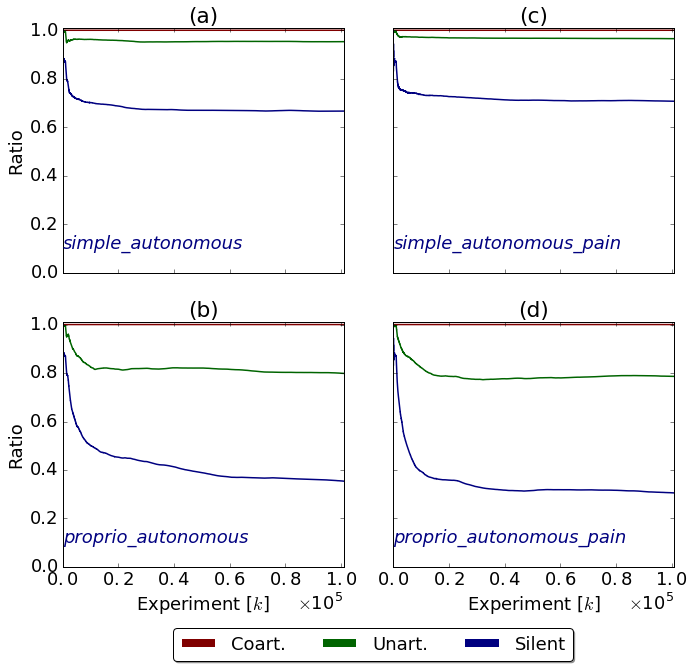

In [17]:
matplotlib.rcParams['figure.figsize'] = (10.0, 9)
matplotlib.rcParams.update({'font.size': 18})

def empty_yticks(ax):
    labels = [item.get_text() for item in ax.get_yticklabels()]
    return ['']*len(labels)

fig, ax = plt.subplots(2,2)
for key, selector in zip(groups_k[::-1],[[0,1],[0,0],[1,1],[1,0]]):
    key = key[0]+ '_' + key[1] 
    plt.sca(ax[selector[0],selector[1]])
    means_unart_av[key] = np.mean(np.array(means_unart_s[key]), axis=0)
    means_coart_av[key] = np.mean(np.array(means_coart_s[key]), axis=0)

    data_plt_coart = incremental_mean(means_coart_av[key])
    data_plt_unart = incremental_mean(means_unart_av[key])
    data_plt_silence  = np.array([1-x for x in np.add(data_plt_coart,data_plt_unart)])

#     data_plt_unart = np.add(data_plt_coart,data_plt_unart)
#     data_plt_silence = np.add(data_plt_silence,data_plt_unart)

    data_plt_unart = np.add(data_plt_silence,data_plt_unart)
    data_plt_coart = np.add(data_plt_coart,data_plt_unart)

    plt.plot(data_plt_coart, linestyle='-', marker='',lw = 1.5,color='maroon')
    plt.plot(data_plt_unart, linestyle='-', marker='',lw = 1.5,color='darkgreen')
    plt.plot(data_plt_silence, linestyle='-', marker='',lw = 1.5,color='navy')

    plt.gca().xaxis.set_major_formatter(xfmt)
    plt.xlabel('Experiment [$k$]')
    plt.xlim([0,n_exp])
    plt.ylim([0,1.01])
    ax[selector[0],selector[1]].text(-1.0,0.1, key,color ='navy', style='italic')
    
for (let, selector) in zip(['a','b','c','d'],[[0,0],[1,0],[0,1],[1,1]]):
    plt.sca(ax[selector[0],selector[1]])
    plt.title('(' + let + ')')
ax[0,1].set_yticklabels(empty_yticks(ax[0,1]))
ax[1,1].set_yticklabels(empty_yticks(ax[1,1]))
ax[0,0].set_xticklabels(empty_yticks(ax[0,1]))
ax[0,1].set_xticklabels(empty_yticks(ax[1,1]))
ax[0,0].set_ylabel('Ratio')
ax[1,0].set_ylabel('Ratio')
ax[0,0].set_xlabel('')
ax[0,1].set_xlabel('')

plt.sca(ax[1,1])
lgd = plt.legend(['Coart.', 'Unart.', 'Silent'],\
           ncol=3,loc='lower right', fontsize=18, bbox_to_anchor=(.67, -0.42),
          fancybox=True, shadow=True)
plt.tight_layout()
for legobj in lgd.legendHandles:
    legobj.set_linewidth(8.0)

In [18]:
fig.savefig('/home/yumilceh/Dropbox/Aplicaciones/ShareLaTeX/PhD_Thesis/chapters/chapter5/images/vt_proportions.eps',\
             format='eps', dpi=1000, bbox_extra_artists=(lgd,), bbox_inches='tight')

In [ ]:
#container for unarticulated productions
means_unart_s = create_dict(groups_k)
means_unart_av = create_dict(groups_k)

#container for coarticulated productions
means_coart_s = create_dict(groups_k)
means_coart_av = create_dict(groups_k)

for directory in ['diva_experiment_thesis_chap_5/', 'diva_experiment_thesis_chap_5_non_painful/']:
    data_files = os.listdir(directory)
    for data_file in (d_f for d_f in data_files if 'sim_data.h5' in d_f):
        data_file = directory + data_file
        conf_file = data_file.replace('sim_data.h5', 'conf.txt')
        conf = read_config_log(conf_file)
        key = conf['type'] + '_' + conf['mode']
        if 'pain' in directory:
            key =  key + '_pain'

        data,foo = load_sim_h5(data_file)
        sensor_data = data.sensor.data.as_matrix(columns=None)

        means_unart_s[key] += [(np.logical_xor(sensor_data[:,2]>0.1, sensor_data[:,5]>0.1)).astype(np.float)[:n_exp]]
        means_coart_s[key] += [(np.logical_and(sensor_data[:,2]>0.1, sensor_data[:,5]>0.1)).astype(np.float)[:n_exp]]


xfmt = matplotlib.ticker.ScalarFormatter(useMathText=True)
xfmt.set_powerlimits((-3,3))

matplotlib.rcParams['figure.figsize'] = (4.0, 3.7)
matplotlib.rcParams.update({'font.size': 18})

figs = {}
for key in groups_k:
    key = key[0]+'_'+key[1] 
    figs.update({key: plt.figure()})
    means_unart_av[key] = np.mean(np.array(means_unart_s[key]), axis=0)
    means_coart_av[key] = np.mean(np.array(means_coart_s[key]), axis=0)

    data_plt_coart = incremental_mean(means_coart_av[key])
    data_plt_unart = incremental_mean(means_unart_av[key])
    data_plt_silence  = np.array([1-x for x in np.add(data_plt_coart,data_plt_unart)])

#         data_plt_unart = np.add(data_plt_coart,data_plt_unart)
#         data_plt_silence = np.add(data_plt_silence,data_plt_unart)

    data_plt_unart = np.add(data_plt_silence,data_plt_unart)
    data_plt_coart = np.add(data_plt_coart,data_plt_unart)

    plt.plot(data_plt_coart, linestyle='-', marker='',lw = 1.5,color='maroon')
    plt.plot(data_plt_unart, linestyle='-', marker='',lw = 1.5,color='darkgreen')
    plt.plot(data_plt_silence, linestyle='-', marker='',lw = 1.5,color='navy')


    plt.gca().xaxis.set_major_formatter(xfmt)
    plt.xlabel('Experiment [$k$]')
    plt.xlim([0,n_exp])
    plt.ylim([0,1.01])
    plt.ylabel('Ratio')
    
lgd = plt.legend(['Coart.', 'Unart.', 'Silent'],\
           ncol=3,loc='lower right', fontsize=18, bbox_to_anchor=(1.2, -0.8),
          fancybox=True, shadow=True)